# Analysis of DART-FISH M1C dataset

In [1]:
import os, numpy as np, pandas as pd
from scipy import stats
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.patches as patches
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.collections as pltCol
from matplotlib.colors import ListedColormap
from matplotlib import colors

from scipy.stats import gaussian_kde

import anndata as AnnData, scanpy as sc
from anndata import read_h5ad


from skimage.io import imread, imshow
from skimage.color import hsv2rgb
from skimage.filters.rank import entropy
from skimage.morphology import dilation, disk
from skimage.measure import label  
from skimage.util import invert
from scipy.spatial import cKDTree
from skimage.segmentation import find_boundaries

import argparse, yaml

matplotlib.rcParams.update({'text.usetex': False, 'svg.fonttype': 'none'})

In [2]:
class DARTFISH_2D:
    def __init__(self, imgs, spots, topLeft = (0, 0), mask=None, name = None, condition=None, 
                 brightfieldChannel=None):
        """ imgs: a dict of dicts containing DART-FISH images. First layer keys are round names. 
            Second layer keys, if existing are channel names
            spots : a dataframe
            topLeft: tuple showing the global coordinates of the top left corner of the image
            mask: a Mask2D object or an array
            name: a string
            condition: a string
            bfCh: a stirng of the for chXX, showing the brightfield channel
        """
        self.imgs = imgs
        self.spots = spots
        self.topLeft = topLeft
        self.mask = mask
        self.name = name
        self.condition = condition
        self.bfCh = brightfieldChannel
        
    def getRoundRGB(self, rnd, hue_dict = {'ch00' : 1/3, 'ch02' : 1/2, 'ch03' : 0}, 
                 contrast_dict = {'ch00' : (10, 150), 'ch02' : (10, 150), 'ch03' : (10, 150)}, 
                    sat = 1):
        return get3ColorRGB(self.imgs[rnd], hue_dict, contrast_dict)
    
    def subsetCoords(self, p1, p2, isPixel = True):
        """ p1 and p2: 2-tuples containing the top-left and bottom-right corners
            isPixel: True if p1 and p2 are pixel coordinates, False if p1 and p2 are physical coordinates
        """
        if isPixel == False:
            raise NotImplementedError('Physical coordinates not implemented')
            
        subImgs = self._subsetAllImages(deepcopy(self.imgs), p1, p2)
        subSpots = DARTFISH_2D.subsetSpots(self.spots, p1, p2, shiftCoords = True)
        
        submask = None
        if self.mask is not None:
            submask = self._subsetImage(self.mask, p1, p2)

        return DARTFISH_2D(subImgs, subSpots, (self.topLeft[0] + p1[0], self.topLeft[1] + p1[1]), mask=submask)
    
    def _subsetImage(self, img, p1, p2):   
        sImg = img.copy()
        sImg = sImg[p1[0]:p2[0], p1[1]:p2[1]]
        return sImg
    
    def _subsetAllImages(self, img_dict, p1, p2):
        for rnd in img_dict:
            if isinstance(img_dict[rnd], dict):
                self._subsetAllImages(img_dict[rnd], p1, p2)
            else:
                img_dict[rnd] = self._subsetImage(img_dict[rnd], p1, p2)
        return img_dict
    
    @staticmethod
    def subsetSpots(spots, p1, p2, shiftCoords = False, coords = ('xg', 'yg')):
        sspots = deepcopy(spots)
        sspots = sspots.loc[(sspots[coords[1]] >= p1[0]) & (sspots[coords[1]] <= p2[0])]
        sspots = sspots.loc[(spots[coords[0]] >= p1[1]) & (spots[coords[0]] <= p2[1])]
        if shiftCoords:
            sspots[coords[0]] = sspots[coords[0]] - p1[1]
            sspots[coords[1]] = sspots[coords[1]] - p1[0]
        return sspots
    
    def getGeneCounts(self):
        return self.spots.groupby('gene').size().sort_values(ascending = False)
    
    @staticmethod
    def segmentForeground(bfIm, entSize=10, entThresh=4, returnEntMap = False):
        """ bfIm: brightfield image
            entSize: integer. Radius of the disk on which the entropy is calculated.
            entThresh: threshold on the entropy 
            returnEntMap: return entropy map if True
            outputs a binary mask
        """
        ent_map = entropy(bfIm, disk(entSize))

        forg = binary_fill_holes(ent_map >= 4) #threshold_otsu(ent_map)
        labelIm = label(forg)
        assert (labelIm.max() > 0)
        bigCC = np.argmax(np.bincount(labelIm.flatten())[1:]) + 1
        forg = labelIm == bigCC
        
        if returnEntMap:
            return forg, ent_map
        else:
            return forg

    def setMask(self, mask):
        self.mask = mask
        
        
#     def plotOneGene(self, gene, ax = None, figsize = (10, 10), color = 'red', ptsize=2):
#         if ax is None:
#             fig, ax = plt.subplots(figsize = figsize)
        
    def plotGene(self, gene, color='rebeccapurple', backgImg=None, backgImg_alpha=0.5, ax=None, 
                 figheight=15, coords=['xg', 'yg'], alpha=1, ptsize=1, backgCmap='gray'):
        spots = deepcopy(self.spots)
        spots = spots.loc[spots['gene'] == gene]
        
        if type(backgImg) == str:
            backgImg = self.imgs[backgImg]
        if ax is None:
            _, ax = plt.subplots(figsize = (figheight / backgImg.shape[0] * backgImg.shape[1], figheight))

        if not backgImg is None:
            ax.imshow(invert(backgImg), cmap=backgCmap, alpha=backgImg_alpha)

        circ_patches = []
        for i, (_, rol) in enumerate(spots.iterrows()):
            circ = plt.Circle((rol[coords[0]], rol[coords[1]]), ptsize, 
                              linewidth = 0.2, fill = True, alpha=alpha, color = color)
            circ_patches.append(circ)

        # add the circles as a collection of patches (faster)
        col1 = pltCol.PatchCollection(circ_patches, match_original=True)
        ax.add_collection(col1)
        
        return ax

def cells2rgb(ad, mask, ct2plot, colordict, plotcolumn='maxCelltype.cls', 
              subcells=True, colorother=None, p1=None, p2=None, blackboundaries=True):
    if (not p1 is None) and (not p2 is None):
        mask = deepcopy(mask[p1[0] : p2[0], p1[1] : p2[1]])
    toplot = np.zeros((*mask.shape, 4))
    usedcells = []
    for i, ct in enumerate(ct2plot):
        print(i, end=" ")
        col = colordict[ct]
        ct_cells = (ad.obs[plotcolumn] == ct) & (subcells)
        ct_cells = ct_cells.index[ct_cells].to_numpy().astype(int)
        usedcells.append(ct_cells)
        toplot[np.isin(mask, ct_cells)] = colors.to_rgba_array(col)
    if blackboundaries:
        toplot[find_boundaries(mask, mode='inner')] = (0, 0, 0, 1)
    print("")
    if (colorother is None) and 'other' not in colordict:
        return toplot
    else:
        if colorother is None:
            colorother = colordict['other']        
        usedcells = np.concatenate(usedcells)
        allcells = np.unique(mask)
        allcells = allcells[allcells != 0]
        othercells = set(allcells) - set(usedcells)
        toplot[np.isin(mask, list(othercells))] = colorother    
        return toplot   

## Load the spot table, nuclear staining, N9, and anchor images into DARTFISH_2D onject

In [3]:
savingdir = "Fig2"
if not os.path.isdir(savingdir):
    os.makedirs(savingdir)
    
spot_df = pd.read_csv('/media/Scratch_SSD/kian/DART-FISH/220912_Paper/Brain/bsg_grt1/3_Decoded/all_spots_filtered.tsv', sep='\t', index_col=0)
nuc_img = imread("/media/Scratch_SSD/kian/DART-FISH/220912_Paper/Brain/bsg_grt1/2_Projected/stitched/draq5_ch00.tif")
n9_img = imread("/media/Scratch_SSD/kian/DART-FISH/220912_Paper/Brain/bsg_grt1/2_Projected/stitched/anchor_ch03.tif")
anchor_img = imread("/media/Scratch_SSD/kian/DART-FISH/220912_Paper/Brain/bsg_grt1/2_Projected/stitched/anchor_ch00.tif")

DF = DARTFISH_2D(imgs={'draq5': nuc_img, 'n9': n9_img, 'anchor': anchor_img}, spots=spot_df)

## Visualize the excitatory vs inhibitory neuron marker genes in the whole M1C tissue

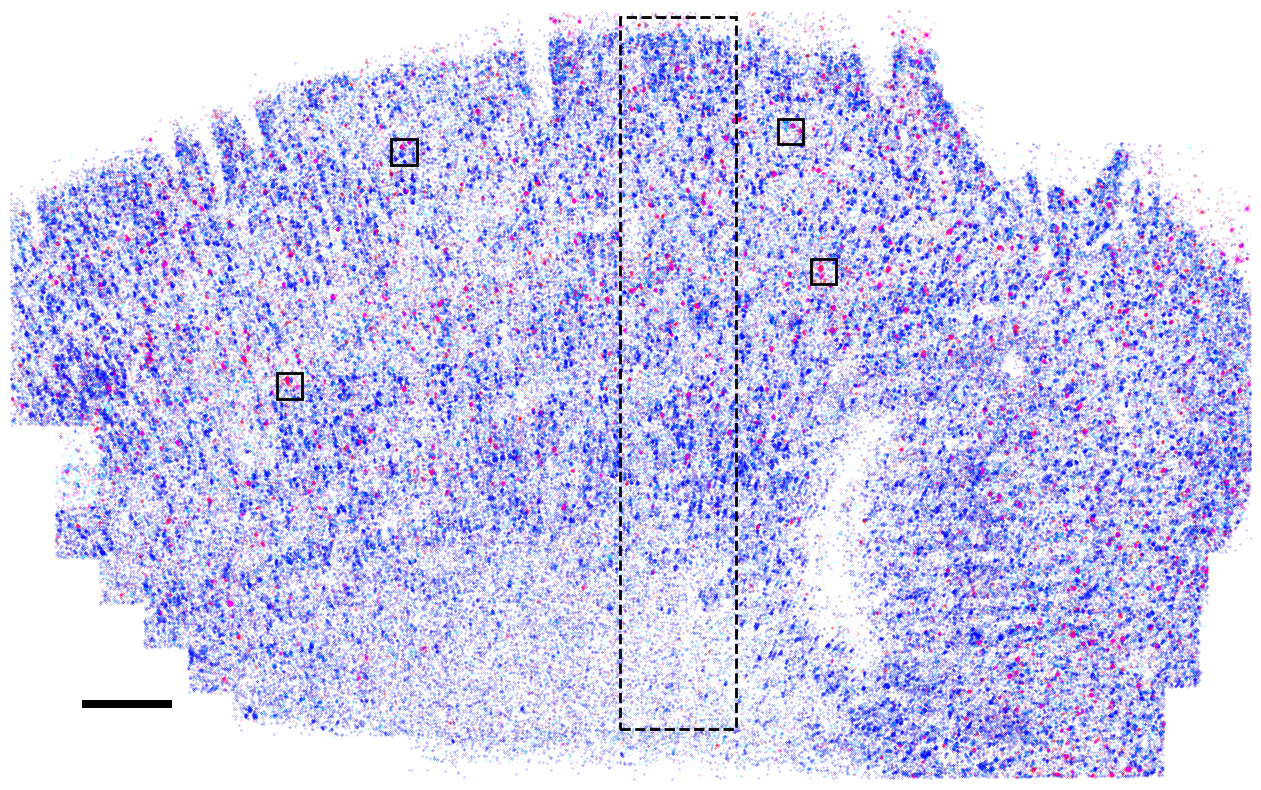

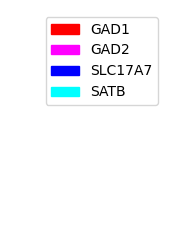

In [4]:
w = DF.imgs['draq5'].shape[1]
h = DF.imgs['draq5'].shape[0]

fig, ax = plt.subplots(figsize=(w/h*10, 10))

ax.imshow(invert(DF.imgs['draq5']), cmap='gray', alpha=0.2)
GAD1_spots = DF.spots[DF.spots['gene']=='GAD1']
ax.scatter(GAD1_spots['xg'], GAD1_spots['yg'], color='red', s=0.04, alpha=0.8, label='GAD1')

GAD2_spots = DF.spots[DF.spots['gene']=='GAD2']
ax.scatter(GAD2_spots['xg'], GAD2_spots['yg'], color='magenta', s=0.04, alpha=0.8, label='GAD2')

SLC17A7_spots = DF.spots[DF.spots['gene']=='SLC17A7']
ax.scatter(SLC17A7_spots['xg'], SLC17A7_spots['yg'], color='blue', s=0.04, alpha=0.8, label='SLC17A7')

SATB2_spots = DF.spots[DF.spots['gene']=='SATB2']
ax.scatter(SATB2_spots['xg'], SATB2_spots['yg'], color='cyan', s=0.04, alpha=0.8, label='SATB2')

# add square box to mark the ROIs
ROI1 = patches.Rectangle((5250, 7500), 500, 500, linewidth=2, edgecolor='black', facecolor='none')
ROI2 = patches.Rectangle((7500, 12100), 500, 500, linewidth=2, edgecolor='black', facecolor='none')
ROI3 = patches.Rectangle((15100, 12500), 500, 500, linewidth=2, edgecolor='black', facecolor='none')
ROI4 = patches.Rectangle((15750, 9750), 500, 500, linewidth=2, edgecolor='black', facecolor='none')
ROIE = patches.Rectangle((12000, 1000), 2276, 14000, linewidth=2, edgecolor='black', linestyle= '--', facecolor='none')
ax.add_patch(ROI1)
ax.add_patch(ROI2)
ax.add_patch(ROI3)
ax.add_patch(ROI4)
ax.add_patch(ROIE)

# add scale bar
ax.add_artist(ScaleBar(0.284, dimension="si-length", units="um", location='lower left', 
                       fixed_value=500, border_pad=5, scale_loc='none'))

# invert y axis
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_axis_off()
ax.margins(x=0, y=0) 
fig.savefig(os.path.join(savingdir, 'Fig2D.png'), dpi=300)

# plot figure legend saparately
plt.figure(figsize=(2, 3))
plt.axis('off')
colordict = {'GAD1': 'red', 'GAD2': 'magenta', 'SLC17A7': 'blue', 'SATB': 'cyan'}
gpatches = [mpatches.Patch(color = colordict[gene], label = gene) for gene in colordict]
plt.legend(handles=gpatches)
plt.savefig(os.path.join(savingdir, "Fig2D_legend.svg"))

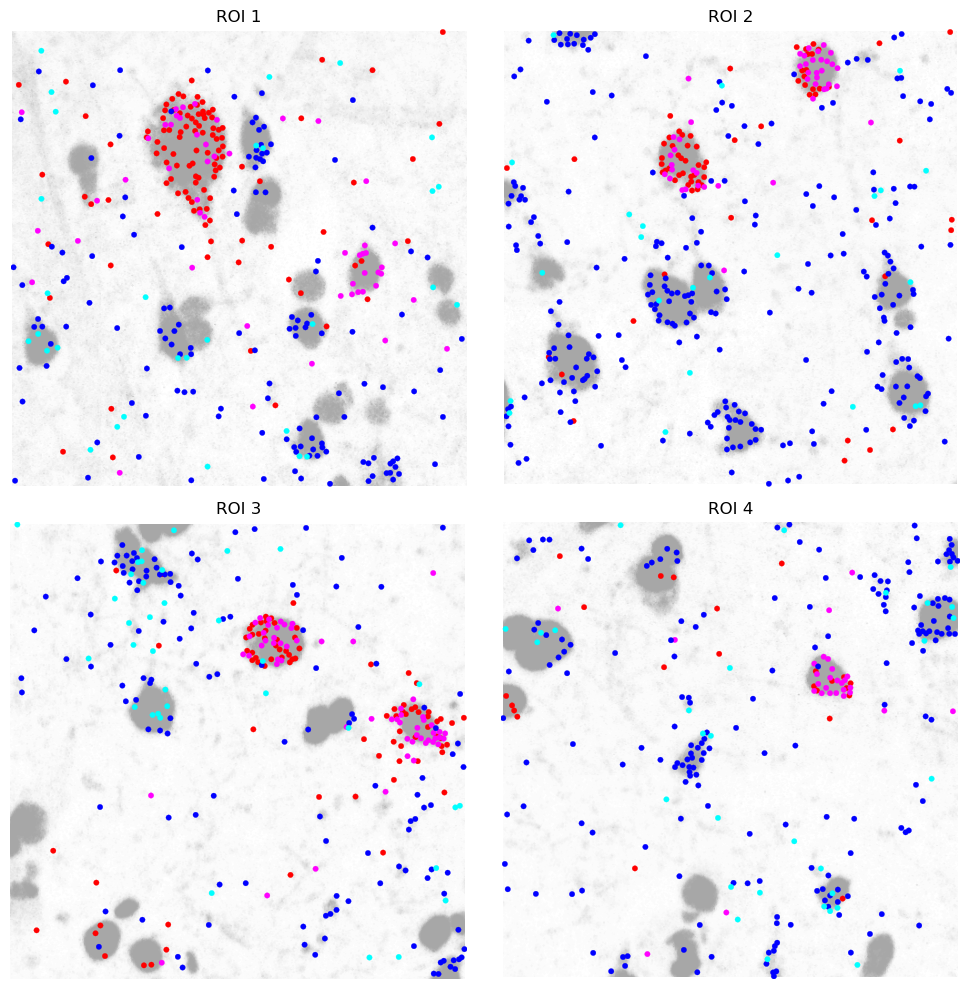

In [5]:
# Zoom in to 4 regions of interest (ROIs) and check the spatial distribution of excitatory neuron markers "SLC17A7", "SATB2" and inhibitory neuron markers, "GAD1", "GAD2"
# Define 4 ROIs: (x1, y1), (x2, y2)
rois = [
    ((7500 ,5250), (8000, 5750)),  # ROI 1
    ((12100 ,7500), (12600, 8000)),  # ROI 2
    ((12500, 15100), (13000, 15600)),  # ROI 3
    ((13000, 14600), (13500, 15100))   # ROI 4
]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()  # Make it easier to loop through

for i, (p1, p2) in enumerate(rois):
    DF_sub = DF.subsetCoords(p1=p1, p2=p2)
    ax = axs[i]

    # Plot genes on the same axes
    DF_sub.plotGene('GAD1', backgImg=DF_sub.imgs['n9'], backgImg_alpha=0.1, ptsize=3, ax=ax, color='red')
    DF_sub.plotGene('GAD2', backgImg=DF_sub.imgs['n9'], backgImg_alpha=0.1, ptsize=3, ax=ax, color='magenta')
    DF_sub.plotGene('SLC17A7', backgImg=DF_sub.imgs['n9'], backgImg_alpha=0.1, ptsize=3, ax=ax, color='blue')
    DF_sub.plotGene('SATB2', backgImg=DF_sub.imgs['n9'], backgImg_alpha=0.1, ptsize=3, ax=ax, color='cyan')

    ax.margins(x=0, y=0)
    ax.invert_yaxis()
    ax.set_axis_off()
    ax.set_title(f"ROI {i+1}", fontsize=12)

# Adjust spacing
plt.tight_layout()

# Save the figure
fig.savefig(os.path.join(savingdir, 'Fig2D_4ROIs.png'), dpi=300)

## Crop a rectangular ROI covering the laminar layer structure of M1C from pial surface to white matter region and compare the spatial distibution of marker genes to the smFISH dataset (RNAscope)

In [ ]:
# Crop a rectangular ROI and plot the genes of interest. The direction of pial surface to white matter regions is from the right to the left
DF_sub = DF.subsetCoords(p1=(1000 ,12000 ), p2=(15000, 14276))
nuc_img =np.flip(np.rot90(DF_sub.imgs['draq5'], k=1, axes=(0,1)), 0)


w = nuc_img.shape[1]
h = nuc_img.shape[0]

genes = ['SLC17A7', 'CUX2', 'CBLN2', 'RORB', 'FEZF2', 'PVALB', 'GAD2', 'LAMP5', 'AQP4', 'APBB1IP']

for gene in genes:
    fig, ax = plt.subplots(figsize=(w/h*6, 6))
    ax.imshow(invert(nuc_img), cmap='gray', alpha=0.15)
    gene_spots = DF_sub.spots[DF_sub.spots['gene']==gene]
    if gene=='SLC17A7':
        ax.scatter(gene_spots['yg'], gene_spots['xg'], color='rebeccapurple', s=3, alpha=0.8, label=gene) # SLC17A7 s=3; RORB s=6; others s=8
    elif gene=='RORB':
        ax.scatter(gene_spots['yg'], gene_spots['xg'], color='rebeccapurple', s=6, alpha=0.8, label=gene)
    else:
        ax.scatter(gene_spots['yg'], gene_spots['xg'], color='rebeccapurple', s=8, alpha=0.8, label=gene)
    
    ax.set_axis_off()
    
    # add scale bar
    ax.add_artist(ScaleBar(0.284, dimension="si-length", units="um", location='lower right', 
                       fixed_value=100, border_pad=2, width_fraction=0.03, scale_loc='none'))
    # fig.add_axes(ax)
    # DF_sub.plotGene(gene, backgImg=DF_sub.imgs['draq5'], backgImg_alpha=0.2, ptsize=12, ax=ax)
    # ax.margins(x=0, y=0) 
    fig.savefig(os.path.join(savingdir, 'DART-FISH_{}.png'.format(gene)), dpi=300)

In [ ]:
# Load the spot table and nuclei staining image from M1C smFISH dataset (RNAscope)
spot_df = pd.read_csv('/media/Scratch_SSD/kian/DART-FISH/220912_Paper/Brain/rnascope1/3_Decoded/all_spots_filtered.tsv', sep='\t', index_col=0)
nuc_img = imread("/media/Scratch_SSD/kian/DART-FISH/220912_Paper/Brain/rnascope1/2_Projected/stitched/draq5_ch00.tif")

nuc_img =np.flip(np.rot90(nuc_img, k=1, axes=(0,1)), 0)

w = nuc_img.shape[1]
h = nuc_img.shape[0]

genes = ['SLC17A7', 'CUX2', 'CBLN2', 'RORB', 'FEZF2', 'PVALB', 'GAD2', 'LAMP5', 'AQP4', 'APBB1IP']

for gene in genes:
    fig, ax = plt.subplots(figsize=(w/h*6, 6))
    ax.imshow(invert(nuc_img), cmap='gray', alpha=0.1)
    gene_spots = spot_df[spot_df['gene']==gene]
    ax.scatter(gene_spots['yg'], gene_spots['xg'], color='rebeccapurple', s=2, alpha=0.8, label=gene)
    ax.set_axis_off()
    
    # add scale bar
    ax.add_artist(ScaleBar(0.113, dimension="si-length", units="um", location='lower right', 
                       fixed_value=100, border_pad=2, width_fraction=0.03, scale_loc='none'))

    fig.savefig(os.path.join(savingdir, 'RNAscope_{}.png'.format(gene)), dpi=300)
    

## Visualize the spatial distribution of some short genes (PCP4, TMSB10, SST, NPY) in M1C DART-FISH dataset

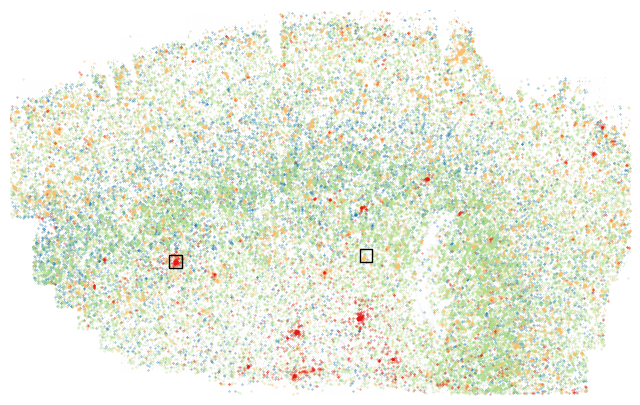

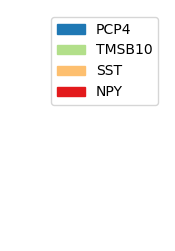

In [8]:
fig, ax = plt.subplots(figsize=(w/h*10/2, 10/2))
ax.imshow(invert(DF.imgs['draq5']), cmap='gray', alpha=0.2)

PCP4_spots = DF.spots[DF.spots['gene']=='PCP4']
ax.scatter(PCP4_spots['xg'], PCP4_spots['yg'], color="#1f78b4", s=0.1, alpha=0.8, label='PCP4')

TMSB10_spots = DF.spots[DF.spots['gene']=='TMSB10']
ax.scatter(TMSB10_spots['xg'], TMSB10_spots['yg'], color='#b2df8a', s=0.1, alpha=0.8, label='TMSB10')

SST_spots = DF.spots[DF.spots['gene']=='SST']
ax.scatter(SST_spots['xg'], SST_spots['yg'], color='#fdbf6f', s=0.1, alpha=0.8, label='SST')

NPY_spots = DF.spots[DF.spots['gene']=='NPY']
ax.scatter(NPY_spots['xg'], NPY_spots['yg'], color='#e31a1c', s=0.1, alpha=0.8, label='NPY')

# add square box to mark the ROIs
ROI1 = patches.Rectangle((6250, 5000), 500, 500, linewidth=1, edgecolor='black', facecolor='none')
ROI2 = patches.Rectangle((13750, 5250), 500, 500, linewidth=1, edgecolor='black', facecolor='none')

ax.add_patch(ROI1)
ax.add_patch(ROI2)


# invert y axis
# ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_axis_off()
ax.margins(x=0, y=0) 
fig.savefig(os.path.join(savingdir, 'Fig3E.png'), dpi=500)

# plot figure legend separately
plt.figure(figsize=(2, 3))
plt.axis('off')
colordict = {'PCP4': '#1f78b4', 'TMSB10': '#b2df8a', 'SST': '#fdbf6f', 'NPY': '#e31a1c'}
gpatches = [mpatches.Patch(color = colordict[gene], label = gene) for gene in colordict]
plt.legend(handles=gpatches)
plt.savefig(os.path.join(savingdir, "Fig3H_shortgene_legend.svg"))

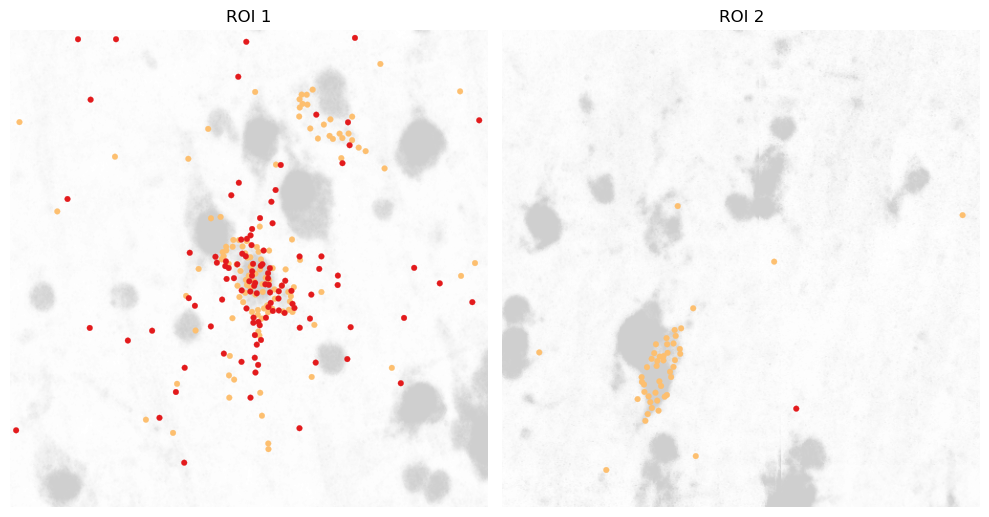

In [9]:
# Zoom in to 2 regions of interest (ROIs) and check the spatial distribution of short genes "SST" and "NPY" 
# Define 4 ROIs: (x1, y1), (x2, y2)
rois = [
    ((5000, 6250), (5500, 6750)),  # ROI 1
    ((5250, 13750), (5750, 14250))  # ROI 2
]

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.flatten()  # Make it easier to loop through

for i, (p1, p2) in enumerate(rois):
    DF_sub = DF.subsetCoords(p1=p1, p2=p2)
    ax = axs[i]

    # Plot genes on the same axes
    DF_sub.plotGene('SST', backgImg=DF_sub.imgs['n9'], backgImg_alpha=0.1, ptsize=3, ax=ax, color='#fdbf6f')
    DF_sub.plotGene('NPY', backgImg=DF_sub.imgs['n9'], backgImg_alpha=0.1, ptsize=3, ax=ax, color='#e31a1c')

    ax.margins(x=0, y=0)
    ax.invert_yaxis()
    ax.set_axis_off()
    ax.set_title(f"ROI {i+1}", fontsize=12)
plt.tight_layout()

# Save the figure
fig.savefig(os.path.join(savingdir, 'Fig3H_2ROIs.png'), dpi=300)

## Cell annotation of M1C DART-FISH cells

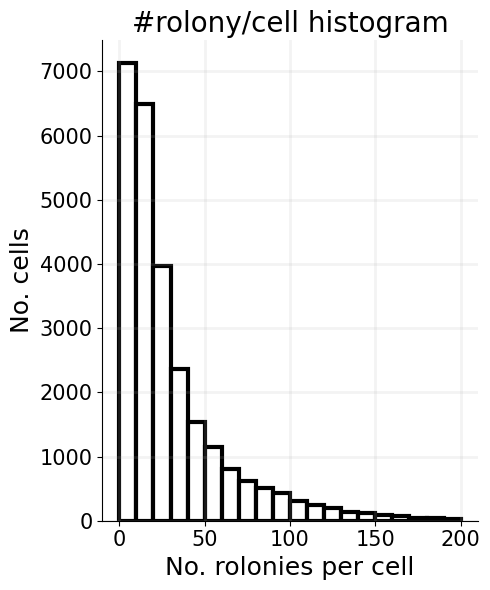

In [10]:
# Load the annotated anndata object
anndatadir = "/media/Scratch_SSD/kian/DART-FISH/220912_Paper/Brain/Analysis_celltyping/230328_clusterAnnotationCosine/anndata_objs/"
df_ad = read_h5ad(os.path.join(anndatadir, "230330_l2manual1_allgenes.h5ad"))

plt.figure(figsize=(5, 6))
sns.histplot(df_ad.X.sum(axis=1), bins=np.arange(0, 210, step=10), color='white', linewidth=3);#
# plt.xlim([0, 120])
plt.xlabel("No. rolonies per cell", fontsize=18)
plt.ylabel("No. cells", fontsize=18)
plt.title('#rolony/cell histogram', fontsize=20)
plt.grid(linewidth=2, alpha=0.15)
sns.despine()
plt.gca().tick_params(labelsize=15)
plt.tight_layout()
plt.savefig("Fig2/Fig2C_rolonyHist.svg")


## Visualize the transcriptomic similarity of each subclass with UMAP

/media/Home_Raid1/chc352/anaconda3/envs/DF_221115/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


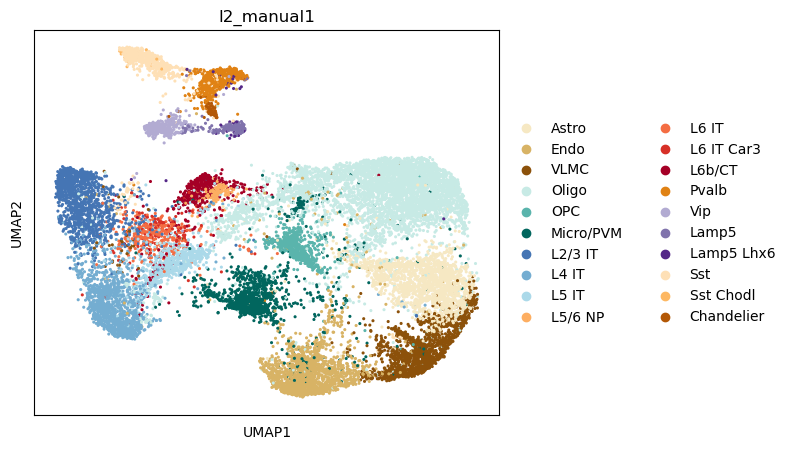

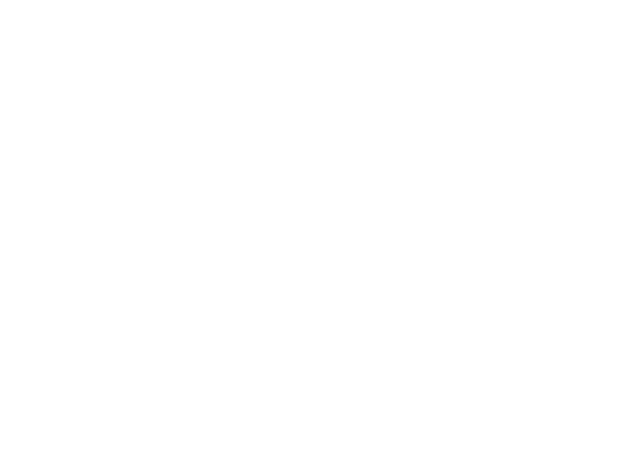

In [11]:
df_ad = read_h5ad(os.path.join(anndatadir, "230330_l2manual1.h5ad"))
colordict = {ct : df_ad.uns['l2_manual1_colors'][i] for i, ct in enumerate(df_ad.obs['l2_manual1'].cat.categories)}

fig, ax = plt.subplots(figsize=(6, 5))
sc.pl.umap(df_ad[~df_ad.obs['l2_manual1'].isna()], color='l2_manual1', s=20, show=True, ax=ax, title=None)
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(savingdir, "Fig3A_l2_manual1_umap.png"), dpi=1000)

## Visualize the expression of marker genes in each subclass with dot plot

/media/Home_Raid1/chc352/anaconda3/envs/DF_221115/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


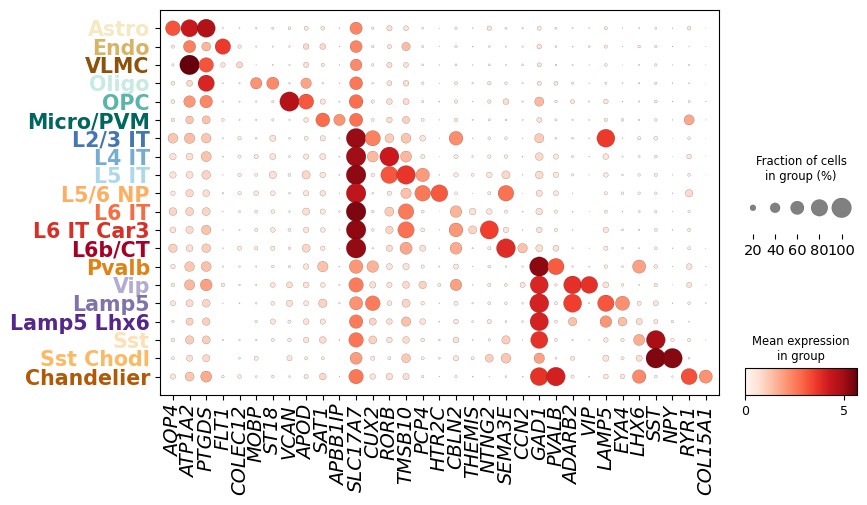

In [12]:
df_ad = read_h5ad(os.path.join(anndatadir, "230330_l2manual1_allgenes.h5ad"))
colordict = {ct : df_ad.uns['l2_manual1_colors'][i] for i, ct in enumerate(df_ad.obs['l2_manual1'].cat.categories)}

markers = ['AQP4', 'ATP1A2', 'PTGDS', 'FLT1', 'COLEC12', 
           'MOBP', 'ST18', 'VCAN', 'APOD', 
           'SAT1', 'APBB1IP', 'SLC17A7', 'CUX2', 'RORB', 'TMSB10', 'PCP4', 'HTR2C', 
           'CBLN2', 'THEMIS',  'NTNG2', 'SEMA3E', 'CCN2', 
           'GAD1', 'PVALB', 'ADARB2', 'VIP', 'LAMP5', 'EYA4', 'LHX6',
           'SST', 'NPY', 'RYR1', 'COL15A1', 
           ]

sc.pp.normalize_total(df_ad, target_sum=1000, inplace=True)
sc.pp.log1p(df_ad)
dpdict = sc.pl.dotplot(df_ad, var_names = markers, groupby='l2_manual1', show=False, figsize=(9, 5), 
                       linewidth=0.1)
dpdict['size_legend_ax'].tick_params(labelsize=10.5)
dpdict['color_legend_ax'].tick_params(labelsize=9)
dpdict['mainplot_ax'].tick_params(axis='y', labelsize=14.8)
dpdict['mainplot_ax'].tick_params(axis='x', labelsize=14)
for txObj in dpdict['mainplot_ax'].get_xticklabels():
    txObj.set_style('oblique')
for txObj in dpdict['mainplot_ax'].get_yticklabels():
    txObj.set_fontweight('bold')
    txObj.set_color(colordict[txObj.get_text()])

plt.savefig(os.path.join(savingdir, "Fig3B_dotplot.svg"), bbox_inches='tight')

## Visualize spaital distribution of each subclass in the whole tissue

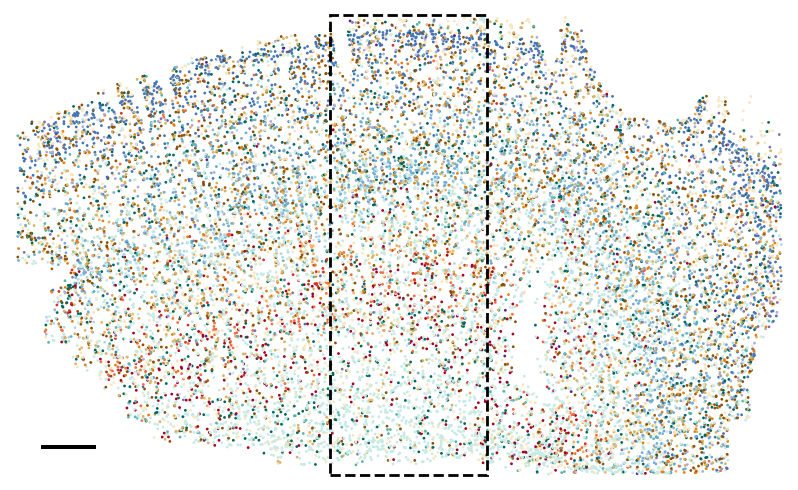

In [13]:
df_ad = read_h5ad(os.path.join(anndatadir, "230330_l2manual1_allgenes.h5ad"))
colordict = {ct : df_ad.uns['l2_manual1_colors'][i] for i, ct in enumerate(df_ad.obs['l2_manual1'].cat.categories)}

w = df_ad.obsm['spatial'][:,1].max()-df_ad.obsm['spatial'][:,1].min()
h = df_ad.obsm['spatial'][:,0].max()-df_ad.obsm['spatial'][:,0].min()

plt_ad = df_ad[~df_ad.obs['l2_manual1'].isna()]
fig, ax = plt.subplots(figsize=(w/h*10/2, 10/2))
ax.scatter(plt_ad.obsm['spatial'][:, 1], plt_ad.obsm['spatial'][:, 0], s=1, alpha=1.0, c=list(map(lambda x: colordict[x], plt_ad.obs['l2_manual1'])))


# add rectangular box to mark the ROIs
ROI1 = patches.Rectangle((10000, 0), 5000, 15200, linewidth=2, edgecolor='black', linestyle='--', facecolor='none')
ax.add_patch(ROI1)

# add scale bar
ax.add_artist(ScaleBar(0.284, dimension="si-length", units="um", location='lower left',
                       fixed_value=500, border_pad=2, scale_loc="none"))
# invert y axis
ax = plt.gca()
ax.set_axis_off()
ax.margins(x=0.01, y=0.01) 

plt.tight_layout()
plt.savefig(os.path.join(savingdir, "Fig3 C-230330_l2_manual1_exc_scatter-zoomout.png"), dpi=1000)


In [14]:
def subsetAnndataRect(adata, p1, p2):
    asub = adata.copy()
    inds = adata.obsm['spatial'][:, 0] >= p1[0]
    inds = inds & (adata.obsm['spatial'][:, 0] < p2[0])
    inds = inds & (adata.obsm['spatial'][:, 1] >= p1[1])
    inds = inds & (adata.obsm['spatial'][:, 1] < p2[1])
    return asub[inds].copy()

selcts = {'exc' : [ 'L2/3 IT', 'L4 IT', 'L5 IT', 'L5/6 NP', 'L6 IT', 'L6 IT Car3', 'L6b/CT'], # L5 ET
          'inh' : ['Pvalb', 'Vip', 'Lamp5', 'Lamp5 Lhx6', 'Sst', 'Sst Chodl', 'Chandelier'], 
          'noNeu' : ['Astro', 'Endo', 'VLMC', 'Oligo', 'OPC', 'Micro/PVM']}

df_ad = read_h5ad(os.path.join(anndatadir, "230330_l2manual1_allgenes.h5ad"))
l2colordict = {ct : df_ad.uns['l2_manual1_colors'][i] for i, ct in enumerate(df_ad.obs['l2_manual1'].cat.categories)}

x1, y1, x2, y2 = 0, 10000, 15200, 15000

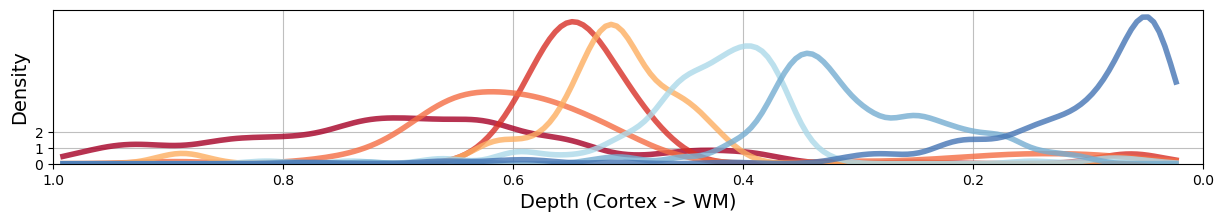

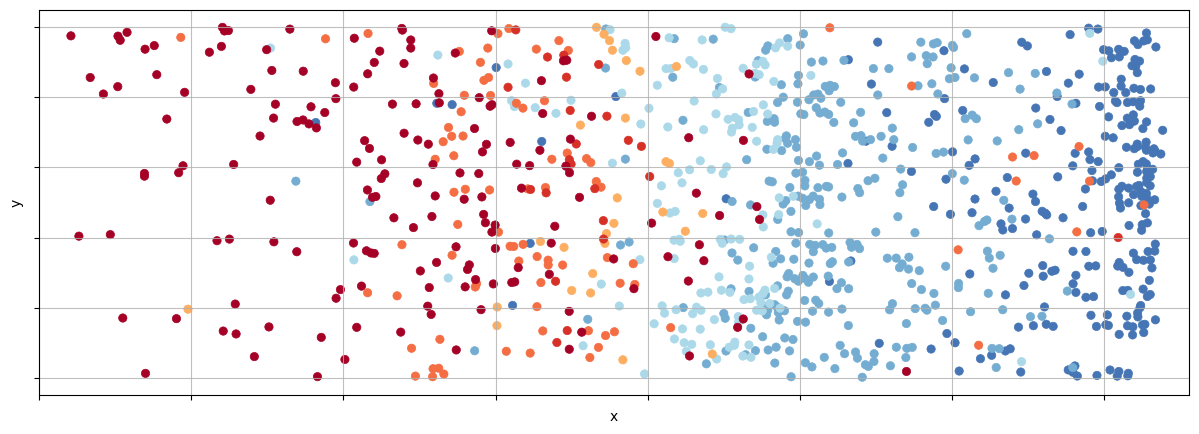

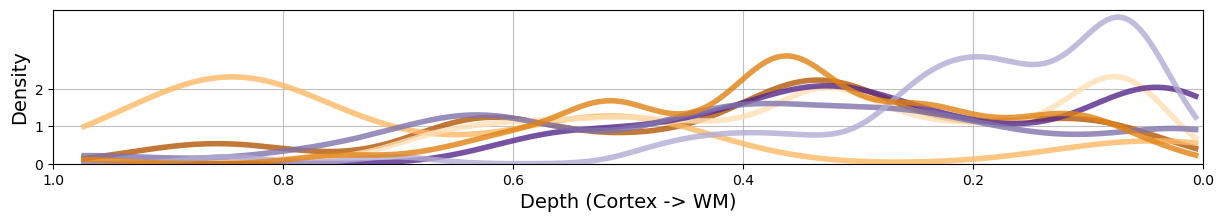

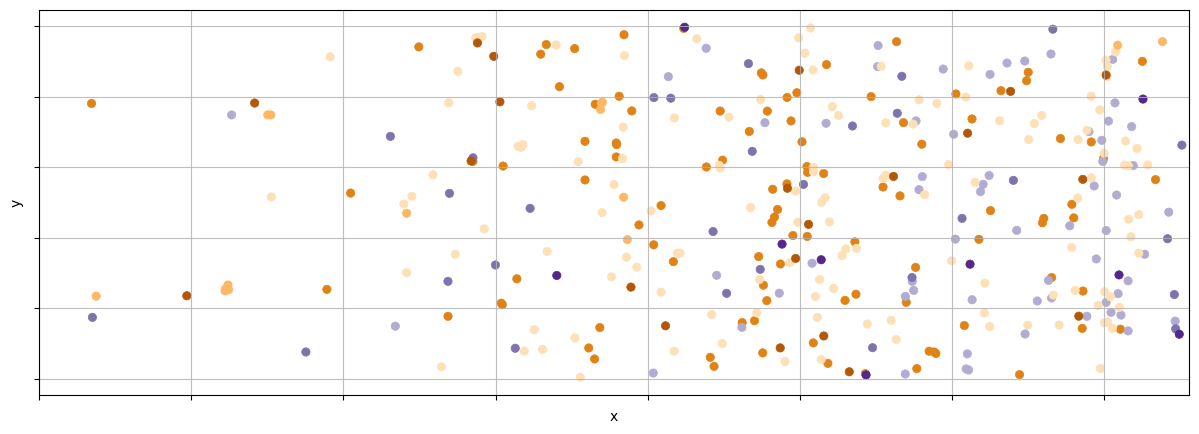

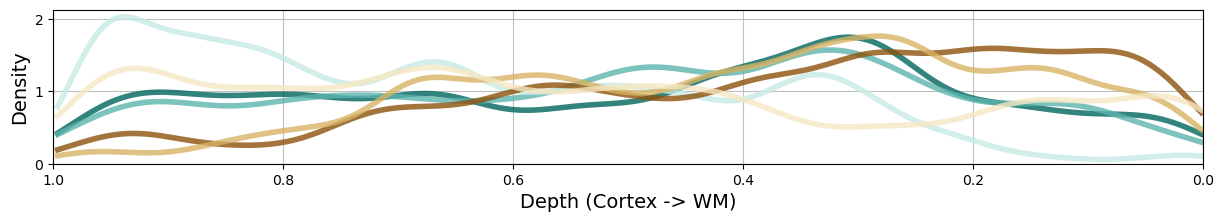

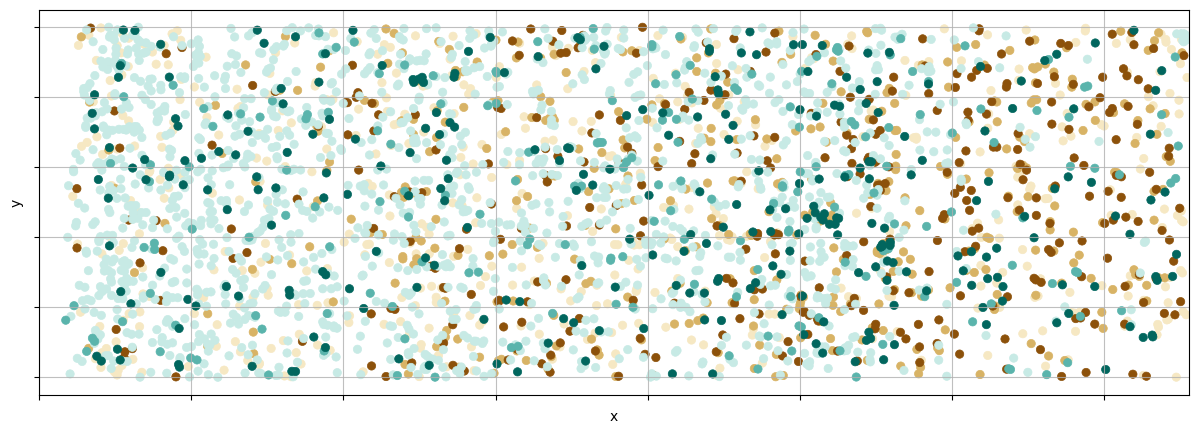

In [15]:
dfrect = subsetAnndataRect(df_ad, p1=(x1, y1), p2=(x2, y2))
h = dfrect.obsm['spatial'][:, 0].max() - dfrect.obsm['spatial'][:, 0].min()
w = dfrect.obsm['spatial'][:, 1].max() - dfrect.obsm['spatial'][:, 1].min()

minx, maxx = dfrect.obsm['spatial'][:, 0].min(), dfrect.obsm['spatial'][:, 0].max()
dfrect.obsm['depth'] = 1 - (dfrect.obsm['spatial'][:, 0] - minx) / (maxx - minx)
getdf = lambda x : pd.DataFrame({'type' : x, 'depth': dfrect[dfrect.obs['l2_manual1'] == x].obsm['depth'].copy(),
                               'x': dfrect[dfrect.obs['l2_manual1'] == x].obsm['spatial'][:,0],
                               'y': dfrect[dfrect.obs['l2_manual1'] == x].obsm['spatial'][:,1]})

for grp in selcts:
    xdf = pd.concat([getdf(ct) for ct in selcts[grp]])
    fig, ax1 = plt.subplots(figsize=(h/w*5, 2))
    # add density plot
    p = sns.kdeplot(xdf, x = 'depth', hue='type', common_norm=False, common_grid=True, cut=0,
                    palette=[colordict[ct] for ct in selcts[grp]], ax=ax1, linewidth=4, bw_adjust=0.5, 
                    alpha=0.8, legend=False)
    ax1.set_xlabel('Depth (Cortex -> WM)', fontsize=14)
    ax1.set_ylabel('Density', fontsize=14)
    ax1.set_yticks(ticks=[0,1,2], miner=False)
    ax1.grid('major', alpha = 0.8)
    ax1.set_xlim([0, 1])
    plt.gca().invert_xaxis()
    # Save just the portion _inside_ the first axis's boundaries
    extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(os.path.join(savingdir, "Fig3 C_{}_celltype_density.svg".format(grp)), bbox_inches=extent, pad_inches=0)
    
    # ax1.savefig(os.path.join(savingdir, "Fig3 C_{}_celltype_density.svg".format(grp)))
    # leg = ax1.get_legend()
    # for line in leg.get_lines():
    #     line.set_linewidth(10)
    # sns.move_legend(p, "upper right", bbox_to_anchor=(1.125, 1), title='', borderpad=.8)
    
    fig, ax2 = plt.subplots(figsize=(h/w*5, 5))
    # add scatter plot
    
    sns.scatterplot(xdf, x = 'x', y = 'y', hue='type', palette=[colordict[ct] for ct in selcts[grp]], ax=ax2, legend=False, edgecolor=None)
    ax2.set_xlim(0, maxx)
    ax2.grid()
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.grid(alpha = 0.8)

    # ax2.scatter(xdf['y'], xdf['x'], s=2.5, alpha=1.0, c=list(map(lambda x: colordict[x], xdf['type'])))
    # ax2.set_axis_off()

    fig.savefig(os.path.join(savingdir, "Fig3 C_{}_celltype_scatter.png".format(grp)))
    
    # Save just the portion _inside_ the second axis's boundaries
    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # fig.savefig(os.path.join(savingdir, "Fig3 C_{}_celltype_scatter.png".format(grp)), bbox_inches=extent, dpi=500)
    
    # plt.gca().invert_xaxis()
    
    # # add scale bar
    # ax2.add_artist(ScaleBar(0.284, dimension="si-length", units="um", location='lower right', 
    #                    fixed_value=100, border_pad=1, scale_loc='top', font_properties={'size':10}))
    
#     plt.tight_layout()
    # fig.savefig(os.path.join(savingdir, "Fig3 C_{}_celltype_scatter.png".format(grp)))
    
#  # plot figure legend
# plt.figure(figsize=(4, 6))
# patches = [mpatches.Patch(color = colordict[cl], label = cl) for cl in colordict]
# plt.legend(handles=patches)
# plt.savefig(os.path.join(savingdir, "Fig3 C_celltype_legend.svg"))

## Quantify the portion of cell classes and subclasses in the whole tissue

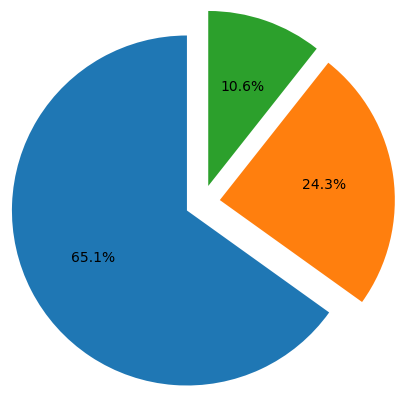

In [16]:
ctcounts = pd.DataFrame(df_ad.obs[~(df_ad.obs['l2_manual1'].isnull())]['cls_l1'].value_counts())#.reset_index()

labels = ['Non-neuronal', 'Excitatory', 'Inhibitory']
sizes = (ctcounts/ctcounts.sum()*100)['cls_l1']

fig, ax = plt.subplots(figsize=(5,5))
wedges, texts, percs = ax.pie(sizes, labels=None, autopct='%1.1f%%', startangle=90)

groups = [[0],  [1], [2]]
radfraction = 0.1

matplotlib.rcParams.update({'text.usetex': False, 'svg.fonttype': 'none'})

for group in groups:
    ang = np.deg2rad((wedges[group[-1]].theta2 + wedges[group[0]].theta1) / 2)
    for j in group:
        center = radfraction * wedges[j].r * np.array([np.cos(ang), np.sin(ang)])
        wedges[j].set_center(center)
        texts[j].set_position(np.array(texts[j].get_position()) + center)
        percs[j].set_position(np.array(percs[j].get_position()) + center)
ax.autoscale(True)
fig.savefig(os.path.join(savingdir, "Fig3G-percentage of cell class.svg"), dpi=300)

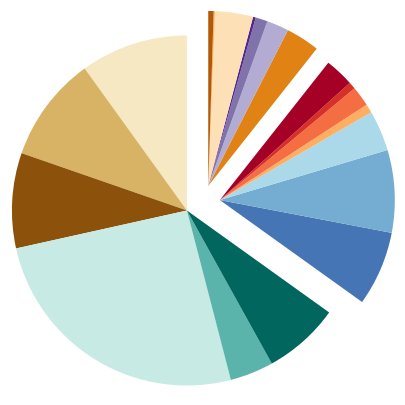

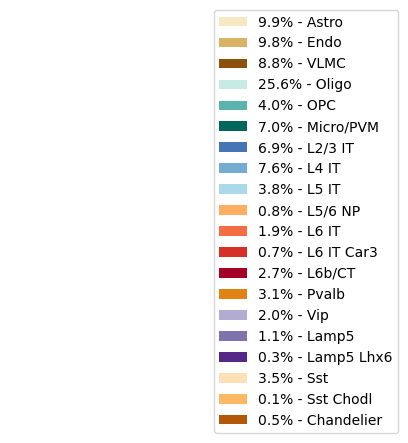

In [17]:
l2colordict = {ct : df_ad.uns['l2_manual1_colors'][i] for i , ct in enumerate(df_ad.obs['l2_manual1'].cat.categories)}

ctcounts = pd.DataFrame(df_ad.obs['l2_manual1'].value_counts())#.reset_index()
ctcounts = ctcounts.loc[list(l2colordict)]
ctcounts = ctcounts.reset_index()
ctcounts['labels'] = np.asarray(ctcounts['index'])
ctcounts['color'] = ctcounts['index'].apply(lambda x: l2colordict[x])
ctcounts['sizes'] = ctcounts['l2_manual1']/ctcounts['l2_manual1'].sum()*100

fig, ax = plt.subplots(figsize=(5,5))
wedges, texts = ax.pie(ctcounts['sizes'], labels=None, colors=ctcounts['color'], startangle=90, labeldistance=1.1)
groups = [[0, 1, 2, 3, 4, 5],  [6, 7, 8, 9, 10, 11, 12], [13, 14, 15, 16, 17, 18, 19]]
radfraction = 0.1

for group in groups:
    ang = np.deg2rad((wedges[group[-1]].theta2 + wedges[group[0]].theta1) / 2)
    for j in group:
        center = radfraction * wedges[j].r * np.array([np.cos(ang), np.sin(ang)])
        wedges[j].set_center(center)
        texts[j].set_position(np.array(texts[j].get_position()) + center)
        # percs[j].set_position(np.array(percs[j].get_position()) + center)
plt.savefig(os.path.join(savingdir, "Fig3 D-percentage of cell subclass.svg"))

# add legend to show percentage of each cell subclass
plt.figure(figsize=(3, 5))
plt.axis('off')
labels = ['{0:1.1f}% - {1}'.format(i,j) for i,j in zip(ctcounts['sizes'], ctcounts['labels'])]
plt.legend(wedges, labels, loc='center right', bbox_to_anchor=(1.7,0.5))
ax.autoscale(True)
plt.savefig(os.path.join(savingdir, "Fig3G-percentage of cell subclass_legend.svg"))

# Supplementary figures

## draq5 vs cDNA

In [18]:
draq5_mask = np.load('/media/Scratch_SSD/kian/DART-FISH/220912_Paper/Brain/bsg_grt1/4_CellAssignment/segmentation_mask_nuc.npy')
cDNA_mask = np.load('/media/Scratch_SSD/kian/DART-FISH/220912_Paper/Brain/bsg_grt1/4_CellAssignment_newseg/segmentation_mask_custom.npy')

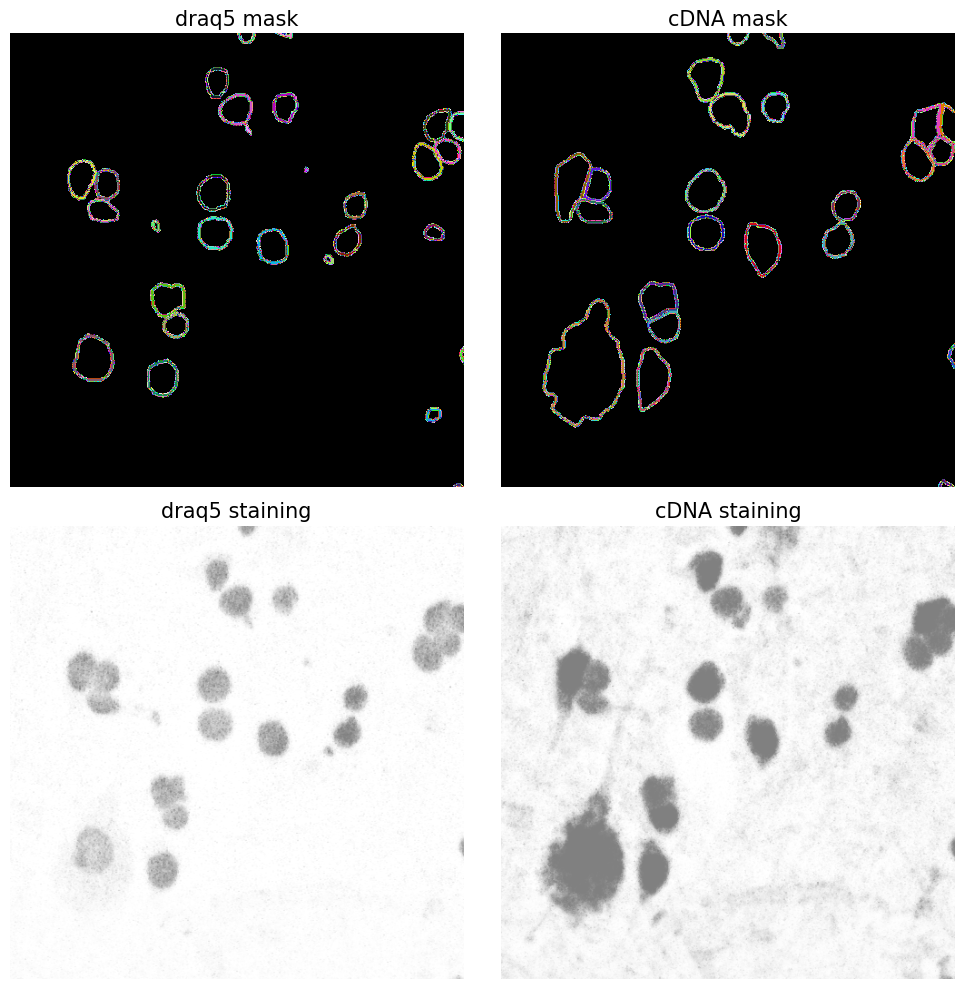

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

## Plotting the nuclei segmentation mask.
myCmap = np.random.rand(np.max(draq5_mask[7500:8000, 5350:5850]) + 1, 4)
myCmap[:, -1] = 1
myCmap[0] = (0, 0, 0, 1)
myCmap = ListedColormap(myCmap)

draq5_maskbrd = np.zeros_like(draq5_mask[7500:8000, 5350:5850])
draq5_bnds = find_boundaries(draq5_mask[7500:8000, 5350:5850], connectivity=1)
draq5_bnds = dilation(draq5_bnds, disk(2))
draq5_maskbrd[draq5_bnds] = draq5_mask[7500:8000, 5350:5850][draq5_bnds]

ax1.imshow(draq5_maskbrd, cmap = myCmap)
ax1.set_title('draq5 mask', fontsize=15)
ax1.set_axis_off()

cDNA_maskbrd = np.zeros_like(cDNA_mask[7500:8000, 5350:5850])
cDNA_bnds = find_boundaries(cDNA_mask[7500:8000, 5350:5850], connectivity=1)
cDNA_bnds = dilation(cDNA_bnds, disk(2))
cDNA_maskbrd[cDNA_bnds] = cDNA_mask[7500:8000, 5350:5850][cDNA_bnds]
ax2.imshow(cDNA_maskbrd, cmap = myCmap)
ax2.set_title('cDNA mask', fontsize=15)
ax2.set_axis_off()

DF_sub = DF.subsetCoords(p1=(7500 ,5350 ), p2=(8000, 5850))
DF_sub.plotGene('', backgImg=DF_sub.imgs['draq5'], backgImg_alpha=0.5, ax=ax3)
ax3.set_title('draq5 staining', fontsize=15)
ax3.set_axis_off()

DF_sub.plotGene('', backgImg=DF_sub.imgs['n9'], backgImg_alpha=0.5, ax=ax4)
ax4.set_title('cDNA staining', fontsize=15)
ax4.set_axis_off()

plt.tight_layout()
plt.savefig('draq5_vs_cDNA.svg', bbox_inches='tight')

## grt vs std cDNA staining

In [20]:
std1_n9_img = imread("/media/Scratch_SSD/kian/DART-FISH/220912_Paper/Brain/bsg_std1/2_Projected/stitched/anchor_ch03.tif")
std1_draq5_img = imread("/media/Scratch_SSD/kian/DART-FISH/220912_Paper/Brain/bsg_std1/2_Projected/stitched/draq5_ch00.tif")

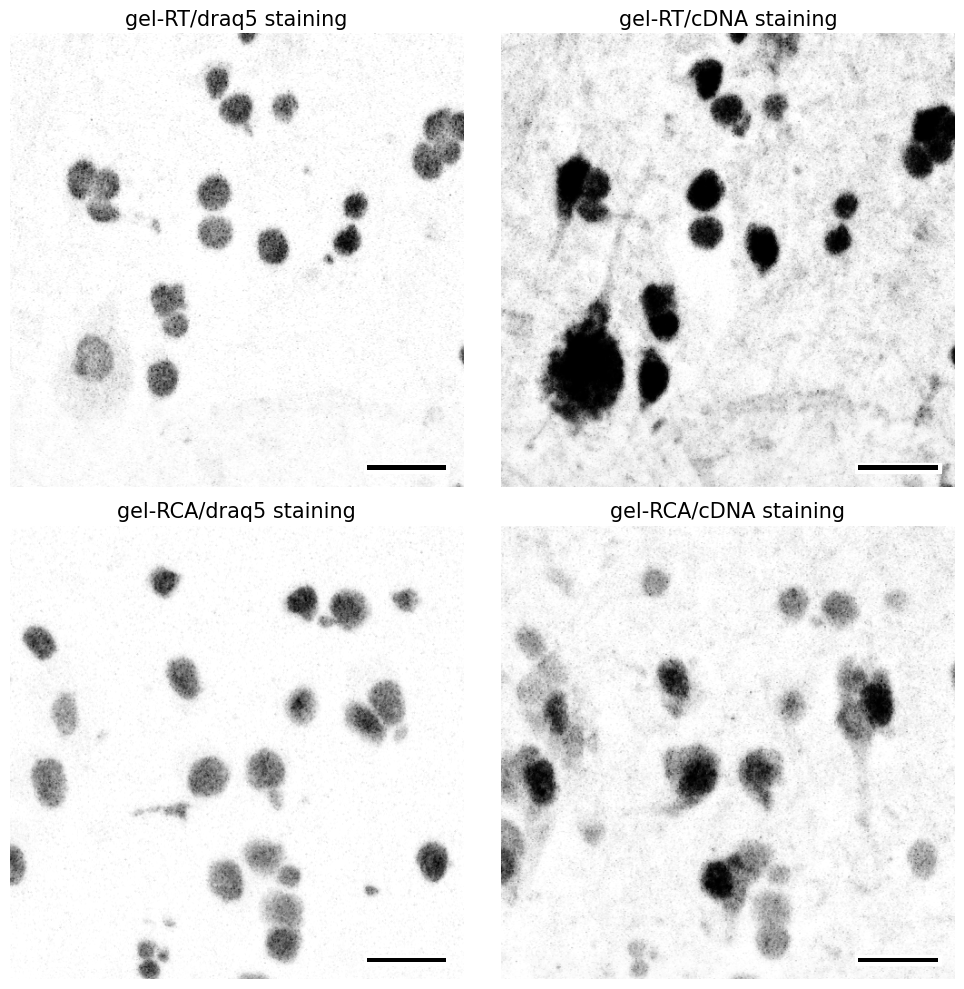

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

DF_sub = DF.subsetCoords(p1=(7500 ,5350 ), p2=(8000, 5850))
DF_sub.plotGene('', backgImg=DF_sub.imgs['draq5'], backgImg_alpha=1, ax=ax1)
ax1.set_title('gel-RT/draq5 staining', fontsize=15)

ax1.add_artist(ScaleBar(0.284, dimension="si-length", units="um", location='lower right',
                       fixed_value=25, border_pad=1, scale_loc="none"))
ax1.set_axis_off()

DF_sub.plotGene('', backgImg=DF_sub.imgs['n9'], backgImg_alpha=1, ax=ax2)
ax2.set_title('gel-RT/cDNA staining', fontsize=15)
ax2.add_artist(ScaleBar(0.284, dimension="si-length", units="um", location='lower right',
                       fixed_value=25, border_pad=1, scale_loc="none"))
ax2.set_axis_off()

ax3.imshow(invert(std1_draq5_img[11000:11500, 17500:18000]), cmap='gray', alpha=1)
ax3.set_title('gel-RCA/draq5 staining', fontsize=15)
ax3.add_artist(ScaleBar(0.284, dimension="si-length", units="um", location='lower right',
                       fixed_value=25, border_pad=1, scale_loc="none"))
ax3.set_axis_off()

ax4.imshow(invert(std1_n9_img[11000:11500, 17500:18000]), cmap='gray', alpha=1)
ax4.set_title('gel-RCA/cDNA staining', fontsize=15)
ax4.add_artist(ScaleBar(0.284, dimension="si-length", units="um", location='lower right',
                       fixed_value=25, border_pad=1, scale_loc="none"))
ax4.set_axis_off()

plt.tight_layout()
plt.savefig('grt_vs_std.svg', bbox_inches='tight')